<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 MultiplicationScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/5.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.739264
1,0.737200
2,0.759168
3,0.741552
4,0.749392
...,...
38875,0.652168
38876,0.664736
38877,0.678984
38878,0.653888


<AxesSubplot: >

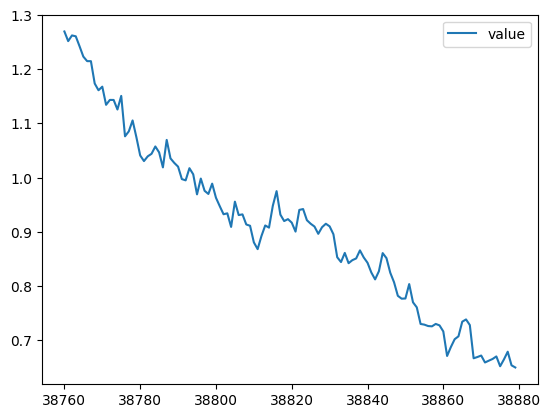

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x/div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_585283/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 103.03302098261682 %
smape 22.83017682194797 %
smape 18.317827056461606 %
smape 17.788536356413488 %
smape 16.59422393490653 %
smape 15.62347257547952 %
smape 15.023182927636288 %
smape 14.46818107379633 %
smape 13.812495996271485 %
smape 13.05686225226879 %
smape 12.056117427279379 %
smape 11.170035332430437 %
smape 10.700414938449162 %
smape 10.248035806400036 %
smape 9.919134715070937 %
smape 9.562418538456162 %
smape 9.559137406513878 %
smape 9.127489139941353 %
smape 9.051437595347215 %
smape 8.921643665267363 %
smape 8.77110287242117 %
smape 8.402139805093931 %
smape 8.438792760696327 %
smape 8.14398449170267 %
smape 8.319774179920902 %
smape 7.708203155078996 %
smape 8.040384816125645 %
smape 7.46673147760506 %
smape 7.668864879953234 %
smape 7.894535586564687 %
smape 7.574705606304676 %
smape 7.537671198567366 %
smape 7.292473627777214 %
smape 7.488125943911006 %
smape 6.971153611458882 %
smape 7.338154827250026 %
smape 6.821240047809847 %
smape 6.7040815207105116 %
smape

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 2.0763957376211692 %
SMAPE 0.9354488921526355 %
SMAPE 1.0997082153044175 %
SMAPE 0.46087179728488087 %
SMAPE 1.225740338380092 %
SMAPE 0.7842701543702334 %
SMAPE 0.3347527537944188 %
SMAPE 0.16917471389024286 %
SMAPE 0.3519769625054323 %
SMAPE 0.49243799507530633 %
SMAPE 0.708672248874791 %
SMAPE 1.1179739111903473 %
SMAPE 1.129533169674687 %
SMAPE 0.21520765538511458 %
SMAPE 0.1976317745666165 %
SMAPE 1.1276002017248175 %
SMAPE 0.915237877686252 %
SMAPE 0.8607660760608269 %
SMAPE 0.47350822973021417 %
SMAPE 0.283101672362136 %
SMAPE 1.513436860100228 %
SMAPE 0.38208587542794703 %
SMAPE 1.0128145949602185 %
SMAPE 1.2163162286160514 %
SMAPE 0.5925595515000168 %
SMAPE 1.7425466115091695 %
SMAPE 0.7542148503162025 %
SMAPE 0.5132567181294689 %
SMAPE 0.5011709342998074 %
SMAPE 0.45181000265256444 %
SMAPE 0.9686605022016009 %
SMAPE 1.8444991577725884 %
SMAPE 1.0285882582429622 %
SMAPE 0.5559537436129176 %
SMAPE 2.5150023577880347 %
SMAPE 0.8933387697834406 %
SMAPE 0.48411300605221186 %

SMAPE 1.9774994395702379 %
SMAPE 1.5289541469683172 %
SMAPE 0.3575904481931502 %
SMAPE 0.23761550343891713 %
SMAPE 0.7236304365105752 %
SMAPE 5.928477936860872 %
SMAPE 0.5203858363638574 %
SMAPE 0.8768706535629462 %
SMAPE 0.9193377578631043 %
SMAPE 1.4467316757545632 %
SMAPE 1.4071223983664822 %
SMAPE 2.327604238940694 %
SMAPE 0.5503916242887499 %
SMAPE 1.0963423175926437 %
SMAPE 0.6574609674707972 %
SMAPE 0.27673532974586124 %
SMAPE 1.5547086628794204 %
SMAPE 0.9135278670109983 %
SMAPE 0.4272726861090632 %
SMAPE 3.1571709173249474 %
SMAPE 1.9255819616082592 %
SMAPE 3.047465824864048 %
SMAPE 1.7512137858357164 %
SMAPE 0.18696585349243833 %
SMAPE 0.9115711075828585 %
SMAPE 0.321471121446848 %
SMAPE 1.274478505278239 %
SMAPE 0.9890906807922875 %
SMAPE 0.804389164980421 %
SMAPE 0.1850902950809541 %
SMAPE 0.8263450611029838 %
SMAPE 0.575598044822982 %
SMAPE 2.4881964370360947 %
SMAPE 0.8655569493239454 %
SMAPE 1.2867735632571566 %
SMAPE 1.5598608772179432 %
SMAPE 0.4323747287708101 %
SMAPE

SMAPE 0.3802908841134922 %
SMAPE 0.08688035643743319 %
SMAPE 0.0978140991849159 %
SMAPE 0.25606096551655355 %
SMAPE 0.3102936928917188 %
SMAPE 0.0916356446541613 %
SMAPE 0.26857234105864336 %
SMAPE 0.1118979589882656 %
SMAPE 0.14163885386551556 %
SMAPE 0.2913835286417452 %
SMAPE 0.23046335520280084 %
SMAPE 0.27238988651242835 %
SMAPE 0.1994658328985679 %
SMAPE 0.4272593808262854 %
SMAPE 0.08505526471890335 %
SMAPE 0.22592615669304905 %
SMAPE 0.2720975171250757 %
SMAPE 0.36126233254435647 %
SMAPE 0.05622100704397325 %
SMAPE 0.24962946738378375 %
SMAPE 0.19137758125123128 %
SMAPE 0.2797490383818513 %
SMAPE 0.1872999176821395 %
SMAPE 0.1559430647685076 %
SMAPE 0.04652419641428196 %
SMAPE 0.23923454322812174 %
SMAPE 0.41588080611245465 %
SMAPE 0.15199299245659859 %
SMAPE 0.1538700449254975 %
SMAPE 0.5906658658077504 %
SMAPE 0.2858345038439438 %
SMAPE 0.3803560852566079 %
SMAPE 0.2530945916187193 %
SMAPE 0.11015023072104668 %
SMAPE 0.10355766598149785 %
SMAPE 0.36633091622570646 %
SMAPE 0.0

SMAPE 0.1746498038410209 %
SMAPE 0.3175884362717625 %
SMAPE 0.11085329458728665 %
SMAPE 0.33145277409846585 %
SMAPE 0.1670782869696268 %
SMAPE 0.17967585812994002 %
SMAPE 0.16925546859420137 %
SMAPE 0.1951784219345427 %
SMAPE 0.3837460152426502 %
SMAPE 0.5964730797877564 %
SMAPE 0.13732666670875915 %
SMAPE 0.17137892817936518 %
SMAPE 0.5465002235987413 %
SMAPE 0.2822474594174764 %
SMAPE 0.19515397670511447 %
SMAPE 0.1380992364024678 %
SMAPE 0.2168176907562156 %
SMAPE 0.20336044162104372 %
SMAPE 0.06912236588118503 %
SMAPE 0.12277250126771834 %
SMAPE 0.25880562987913436 %
SMAPE 0.06790475608431734 %
SMAPE 0.1146215526459855 %
SMAPE 0.21093318738712696 %
SMAPE 0.15032225892718998 %
SMAPE 0.08351148027304589 %
SMAPE 0.3075619344366487 %
SMAPE 0.06956291743199472 %
SMAPE 0.27259704074822366 %
SMAPE 0.14858270623790304 %
SMAPE 0.34564145333570195 %
SMAPE 0.12551924570288975 %
SMAPE 0.17187558362275013 %
SMAPE 0.1195377661351813 %
SMAPE 0.1764476280013696 %
SMAPE 0.0935356271938872 %
SMAPE 0

SMAPE 0.5345770207313763 %
SMAPE 0.191237983181054 %
SMAPE 0.3052309784507088 %
SMAPE 0.6519967731474026 %
SMAPE 0.2039961668924661 %
SMAPE 0.21945268410217977 %
SMAPE 0.14558118075001403 %
SMAPE 0.14324955034680897 %
SMAPE 0.5343599756688491 %
SMAPE 0.21127723455174416 %
SMAPE 0.06247912961293878 %
SMAPE 0.13620047916876388 %
SMAPE 0.09754776031877554 %
SMAPE 0.20235743200828438 %
SMAPE 0.38174557646243557 %
SMAPE 0.3748660610299339 %
SMAPE 0.13947022910724627 %
SMAPE 0.34123782690858206 %
SMAPE 0.19406816902875335 %
SMAPE 0.12871426191031787 %
SMAPE 0.15005562791611737 %
SMAPE 0.12738220282244583 %
SMAPE 0.29402354566263966 %
SMAPE 0.689563991396426 %
SMAPE 0.14030557196656446 %
SMAPE 0.3404952632945424 %
SMAPE 0.16789213288302562 %
SMAPE 0.31085773470294953 %
SMAPE 0.17876710355494652 %
SMAPE 1.108226152445468 %
SMAPE 0.4568165695600328 %
SMAPE 0.1893074232066283 %
SMAPE 0.1353637376014376 %
SMAPE 0.10504940604050717 %
SMAPE 0.09713150795630554 %
SMAPE 0.11469581843994092 %
SMAPE 0.

SMAPE 0.8181197748926934 %
SMAPE 0.131885355812301 %
SMAPE 0.3515162371513725 %
SMAPE 0.17496894786745543 %
SMAPE 0.7954270769987488 %
SMAPE 1.4000083846876805 %
SMAPE 0.7555654930113178 %
SMAPE 0.30564814153694897 %
SMAPE 1.3816033356706612 %
SMAPE 0.8142973561334657 %
SMAPE 0.1959917286471864 %
SMAPE 0.03673892282677116 %
SMAPE 0.11897005884202372 %
SMAPE 0.7236421320121735 %
SMAPE 0.3567861600604374 %
SMAPE 0.5130881849933644 %
SMAPE 0.6018088541495672 %
SMAPE 0.3876593147579115 %
SMAPE 0.31978556452753537 %
SMAPE 0.518095053936122 %
SMAPE 0.46916777411388466 %
SMAPE 0.6224210870386742 %
SMAPE 0.8058299747572164 %
SMAPE 0.18962424237679443 %
SMAPE 1.81023119740712 %
SMAPE 0.2953509773542464 %
SMAPE 2.54421983903012 %
SMAPE 2.263958056446427 %
SMAPE 0.7288941106326092 %
SMAPE 1.5884746602896485 %
SMAPE 0.20076761235759474 %
SMAPE 0.8206296905809722 %
SMAPE 0.3645818663726459 %
SMAPE 0.2806739617444691 %
SMAPE 0.31714292725337145 %
SMAPE 0.31961140658677323 %
SMAPE 0.8778584087849595 

SMAPE 0.7279912569429143 %
SMAPE 0.2555189974427776 %
SMAPE 1.392119616591117 %
SMAPE 0.6271888707760809 %
SMAPE 1.4350709106329305 %
SMAPE 0.13240806210887968 %
SMAPE 0.7434532323918575 %
SMAPE 1.8194653310874855 %
SMAPE 0.242953014014347 %
SMAPE 0.21203868017619243 %
SMAPE 1.4849937200633576 %
SMAPE 0.398619496028914 %
SMAPE 0.44468107003012847 %
SMAPE 0.401478444080567 %
SMAPE 0.4327641641139053 %
SMAPE 0.27731631732240203 %
SMAPE 0.46010631154422305 %
SMAPE 0.9292899584252154 %
SMAPE 0.6008492363453115 %
SMAPE 0.7725611083802733 %
SMAPE 0.4826445032231277 %
SMAPE 0.31471436156243726 %
SMAPE 0.45440471658685055 %
SMAPE 0.5556451274987921 %
SMAPE 0.2576544542971533 %
SMAPE 0.14594453120685102 %
SMAPE 0.9594775770165144 %
SMAPE 0.8219388336474367 %
SMAPE 0.5803180631264695 %
SMAPE 0.3887740631002998 %
SMAPE 0.4221479011719111 %
SMAPE 0.12376710583697559 %
SMAPE 0.21296012968923606 %
SMAPE 0.958135586217395 %
SMAPE 0.4736369606216612 %
SMAPE 0.5398083774416591 %
SMAPE 1.185108056415629

SMAPE 0.2506829656485934 %
SMAPE 0.10777392814179622 %
SMAPE 0.14967458920796162 %
SMAPE 0.18001565075974213 %
SMAPE 0.3525728004360644 %
SMAPE 0.33756954068559253 %
SMAPE 0.08442868186466512 %
SMAPE 0.2529300173255251 %
SMAPE 0.12133891527253127 %
SMAPE 0.28569114266429096 %
SMAPE 0.405526970514984 %
SMAPE 0.2434540329495576 %
SMAPE 0.149414611899374 %
SMAPE 0.19630702496215235 %
SMAPE 0.09378644041134976 %
SMAPE 0.25561654509601794 %
SMAPE 0.10474480587481594 %
SMAPE 0.1993580847931753 %
SMAPE 0.15476814037538134 %
SMAPE 0.1725072076108063 %
SMAPE 0.2933924567128088 %
SMAPE 0.05854784977418604 %
SMAPE 0.13781272200503736 %
SMAPE 0.21744817735384459 %
SMAPE 0.1837605189975875 %
SMAPE 0.061974439266577974 %
SMAPE 0.16858395100871348 %
SMAPE 0.1658292211996013 %
SMAPE 0.11932485737270328 %
SMAPE 0.4439735654695482 %
SMAPE 0.21587523848756973 %
SMAPE 0.19887803333631382 %
SMAPE 0.24706197580599112 %
SMAPE 0.1303467798361453 %
SMAPE 0.08212729669467222 %
SMAPE 0.10878501642241645 %
SMAPE 

SMAPE 0.10278623547128518 %
SMAPE 0.2654380965200289 %
SMAPE 0.19761673584434902 %
SMAPE 0.08540402192784313 %
SMAPE 0.05790261141225982 %
SMAPE 0.12433153055826551 %
SMAPE 0.17113524240630795 %
SMAPE 0.3998253318641219 %
SMAPE 0.1808476547198552 %
SMAPE 0.06267861652270312 %
SMAPE 0.06468261478403292 %
SMAPE 0.25745896079706654 %
SMAPE 0.35304483438498124 %
SMAPE 0.29984796317876317 %
SMAPE 0.04219019188826678 %
SMAPE 0.14416034673513423 %
SMAPE 0.21672965558718715 %
SMAPE 0.014604116057853389 %
SMAPE 0.07168275279559566 %
SMAPE 0.33422269519678593 %
SMAPE 0.24737019644362593 %
SMAPE 0.07123914704061463 %
SMAPE 0.19222553118652286 %
SMAPE 0.16870008784826496 %
SMAPE 0.1678086927444724 %
SMAPE 0.0852935980388736 %
SMAPE 0.24357652598473578 %
SMAPE 0.11495847676178526 %
SMAPE 0.23464447099399874 %
SMAPE 0.2165429383016999 %
SMAPE 0.12883104787761113 %
SMAPE 0.053303132290238864 %
SMAPE 0.12301810320377625 %
SMAPE 0.16254832796130358 %
SMAPE 0.11229655108149927 %
SMAPE 0.0515650413435651

SMAPE 0.20597452304900796 %
SMAPE 0.06421244367084 %
SMAPE 0.14321034610838979 %
SMAPE 0.30414095323794754 %
SMAPE 0.18729634050282584 %
SMAPE 0.16333569688140415 %
SMAPE 0.1265143123036978 %
SMAPE 0.3628398635901249 %
SMAPE 0.16534677283561905 %
SMAPE 0.3364379679759395 %
SMAPE 0.06492923970318287 %
SMAPE 0.23029490024782717 %
SMAPE 0.11894665337877086 %
SMAPE 0.39696026741876267 %
SMAPE 0.39737542638613377 %
SMAPE 0.40387730284851386 %
SMAPE 0.5749657224660041 %
SMAPE 0.16108139300376934 %
SMAPE 0.2399497753358446 %
SMAPE 0.1604748261270288 %
SMAPE 0.3095703925409907 %
SMAPE 0.2222820770111866 %
SMAPE 0.39712813698133687 %
SMAPE 0.713723082632896 %
SMAPE 0.15777601372474237 %
SMAPE 0.08095866087460735 %
SMAPE 0.2654284023283253 %
SMAPE 0.4100015859803534 %
SMAPE 0.23603835077801705 %
SMAPE 0.19052259946329286 %
SMAPE 0.25620355452910815 %
SMAPE 0.10540391267022642 %
SMAPE 0.4398836323816795 %
SMAPE 0.11203033447782218 %
SMAPE 0.3826847263948139 %
SMAPE 0.07279232386645162 %
SMAPE 0.4

SMAPE 3.361274798517115 %
SMAPE 3.686116054902868 %
SMAPE 3.1770207950030454 %
SMAPE 2.719955518259667 %
SMAPE 0.7332847103389213 %
SMAPE 0.5717186999754631 %
SMAPE 0.7661407589548617 %
SMAPE 0.4979846276182798 %
SMAPE 0.22587993900135928 %
SMAPE 0.8794636862876358 %
SMAPE 0.4900385489308974 %
SMAPE 0.7432894251651305 %
SMAPE 2.260354025232573 %
SMAPE 0.49042104095860845 %
SMAPE 0.8279199684548075 %
SMAPE 0.5312475716951894 %
SMAPE 1.4697340528036875 %
SMAPE 3.4466324947570683 %
SMAPE 0.25539502538867964 %
SMAPE 3.4205063500976394 %
SMAPE 0.41668283037870424 %
SMAPE 0.18182659189824335 %
SMAPE 0.6769806362062809 %
SMAPE 4.879103994957404 %
SMAPE 0.10988679411093473 %
SMAPE 1.013694771707378 %
SMAPE 0.5252905158267822 %
SMAPE 1.2875206292010262 %
SMAPE 0.8797931346634869 %
SMAPE 1.1043004443272366 %
SMAPE 3.5107458301936276 %
SMAPE 5.5831112196610775 %
SMAPE 4.293904211692279 %
SMAPE 2.2732577709757606 %
SMAPE 3.354445982695324 %
SMAPE 3.4471763173642103 %
SMAPE 1.5497634288622066 %
SMA

SMAPE 0.6727827214187414 %
SMAPE 0.661771152061192 %
SMAPE 0.4862790625356866 %
SMAPE 0.19912476021443126 %
SMAPE 0.40890966562892567 %
SMAPE 0.11952369189475576 %
SMAPE 0.2465799439269176 %
SMAPE 0.43623993006622186 %
SMAPE 0.26071238419262954 %
SMAPE 0.15158734637770976 %
SMAPE 0.26547419886264834 %
SMAPE 0.4977586664358569 %
SMAPE 0.2571942073855098 %
SMAPE 0.8805411247303709 %
SMAPE 0.38716434901743924 %
SMAPE 0.47509958336922864 %
SMAPE 0.09684252362319512 %
SMAPE 0.37976523994984746 %
SMAPE 0.8005353500716411 %
SMAPE 0.11859439399677285 %
SMAPE 0.21864856077900185 %
SMAPE 0.20224941073684022 %
SMAPE 0.08416676211845697 %
SMAPE 0.35189310532405216 %
SMAPE 0.15844700453453697 %
SMAPE 0.15672698819253128 %
SMAPE 0.33261215254606213 %
SMAPE 0.35306121596420326 %
SMAPE 0.15228004693926778 %
SMAPE 0.23230233825142932 %
SMAPE 0.10888913607050199 %
SMAPE 0.15824371670953497 %
SMAPE 0.20268132791215976 %
SMAPE 0.04221178885200061 %
SMAPE 0.6288502568841068 %
SMAPE 0.4260624227790686 %
SMA

SMAPE 0.13211538907125941 %
SMAPE 0.07306246970256325 %
SMAPE 0.1616050985826405 %
SMAPE 0.12021197908779868 %
SMAPE 0.12142456073524954 %
SMAPE 0.26518973609381646 %
SMAPE 0.30245028601711965 %
SMAPE 0.10942410977440886 %
SMAPE 0.2822723897788819 %
SMAPE 0.2471559243676893 %
SMAPE 0.3840799703302764 %
SMAPE 0.054972829471125806 %
SMAPE 0.2646384727761415 %
SMAPE 0.13899407096141658 %
SMAPE 0.2434637252590619 %
SMAPE 0.10377912975582147 %
SMAPE 0.2195175858651055 %
SMAPE 0.0735372681865556 %
SMAPE 0.09806770834347844 %
SMAPE 0.19962701181066222 %
SMAPE 0.3656870213399088 %
SMAPE 0.48674480929912534 %
SMAPE 0.3386041167723306 %
SMAPE 0.2376620253785404 %
SMAPE 0.15881291304424394 %
SMAPE 0.24541318809315268 %
SMAPE 0.08758300516637973 %
SMAPE 0.21582406482048097 %
SMAPE 0.1386863793768498 %
SMAPE 0.2484772260427235 %
SMAPE 0.2030101587206445 %
SMAPE 0.17187434880361252 %
SMAPE 0.2305976977222599 %
SMAPE 0.35778449572535465 %
SMAPE 0.052821320906332396 %
SMAPE 0.09608584435920875 %
SMAPE

SMAPE 0.11088080158788216 %
SMAPE 0.15909537091420134 %
SMAPE 0.30991754010619843 %
SMAPE 0.36188064819242527 %
SMAPE 0.19201715391272955 %
SMAPE 0.08614793717438829 %
SMAPE 0.46029940689550125 %
SMAPE 0.4977637331182905 %
SMAPE 0.16449447980994591 %
SMAPE 0.2581309710822097 %
SMAPE 0.27638037460292253 %
SMAPE 0.12480635539304785 %
SMAPE 0.23359346786673996 %
SMAPE 0.20847675121331125 %
SMAPE 0.3062601622023067 %
SMAPE 0.08869498386593477 %
SMAPE 0.15800439649137843 %
SMAPE 0.08809065761016655 %
SMAPE 0.20388696010923013 %
SMAPE 0.35334857243969964 %
SMAPE 0.46284561946140457 %
SMAPE 0.5121667002385948 %
SMAPE 0.3994092858192744 %
SMAPE 0.21435779974581237 %
SMAPE 0.11124105385147232 %
SMAPE 0.12364343401350197 %
SMAPE 0.10408424745122602 %
SMAPE 0.08300130361385527 %
SMAPE 0.08245064599339003 %
SMAPE 0.15683572083707986 %
SMAPE 0.1671504307307714 %
SMAPE 0.33086561142135906 %
SMAPE 0.13835879841644783 %
SMAPE 0.10637514345535237 %
SMAPE 0.28880131542513254 %
SMAPE 0.3802936665915695 %

SMAPE 0.2683709460434329 %
SMAPE 0.22025194852267305 %
SMAPE 0.228568528264077 %
SMAPE 0.4521831940064658 %
SMAPE 0.08480352365029376 %
SMAPE 0.5588776589637519 %
SMAPE 0.18936120679836677 %
SMAPE 0.3891620786589556 %
SMAPE 0.1960815070353874 %
SMAPE 0.30538988903936115 %
SMAPE 0.4305385171282978 %
SMAPE 0.20078126662701834 %
SMAPE 0.3573105547502564 %
SMAPE 0.2761928175314097 %
SMAPE 0.290030686556463 %
SMAPE 0.16616253232564304 %
SMAPE 0.14183053283522895 %
SMAPE 0.10469729360193013 %
SMAPE 0.19917221328910273 %
SMAPE 0.06720981235412182 %
SMAPE 0.192919484855679 %
SMAPE 0.14328488598403055 %
SMAPE 0.2324045403920536 %
SMAPE 0.2730122700213542 %
SMAPE 0.39142605399683816 %
SMAPE 0.48226150246023275 %
SMAPE 0.2256732572932378 %
SMAPE 0.7141400212276494 %
SMAPE 0.17788789954101958 %
SMAPE 0.09039289573229325 %
SMAPE 0.24594830146861568 %
SMAPE 0.3201892504694115 %
SMAPE 0.25062893718859414 %
SMAPE 0.14058977278568818 %
SMAPE 0.17626625156344744 %
SMAPE 0.22835719115573738 %
SMAPE 0.447

SMAPE 0.5646308261493687 %
SMAPE 0.6330411927119712 %
SMAPE 1.1512458234647056 %
SMAPE 0.1581934498967712 %
SMAPE 0.605809749380569 %
SMAPE 0.6091415438331751 %
SMAPE 0.3757556974160252 %
SMAPE 1.0316037335942383 %
SMAPE 1.360907246969873 %
SMAPE 1.8334592500468716 %
SMAPE 0.7444073611986823 %
SMAPE 0.8027161772733962 %
SMAPE 0.5682532957362127 %
SMAPE 0.26966421939641805 %
SMAPE 0.7197024808338028 %
SMAPE 1.2013702320946322 %
SMAPE 1.2271937303714822 %
SMAPE 1.6373641349346144 %
SMAPE 0.7479412605207472 %
SMAPE 1.2833784230606398 %
SMAPE 0.46346031406574184 %
SMAPE 0.6068690244492245 %
SMAPE 0.7155123808552162 %
SMAPE 1.441178960610614 %
SMAPE 1.2407136173560502 %
SMAPE 0.3888481489975675 %
SMAPE 0.597221696077213 %
SMAPE 1.6526106021992746 %
SMAPE 1.0539683734677965 %
SMAPE 1.3652930828611716 %
SMAPE 1.7399984827661683 %
SMAPE 0.6109566407103557 %
SMAPE 1.164778462094091 %
SMAPE 0.6861198105034418 %
SMAPE 1.1854355392042635 %
SMAPE 0.26021838708766154 %
SMAPE 0.5815598754415987 %
SMA

SMAPE 0.06901274285382897 %
SMAPE 0.35639671326111966 %
SMAPE 0.07473714097432094 %
SMAPE 0.268509997658839 %
SMAPE 0.1981987838644272 %
SMAPE 0.14734529046290845 %
SMAPE 0.3061225496849147 %
SMAPE 0.11605233394766401 %
SMAPE 0.07792941320326463 %
SMAPE 0.5760522596983719 %
SMAPE 0.43139704437635373 %
SMAPE 0.5369768139216831 %
SMAPE 0.30455562222482513 %
SMAPE 0.29065084471631053 %
SMAPE 0.09673037145421404 %
SMAPE 0.14467553257054533 %
SMAPE 0.205963824409082 %
SMAPE 0.7746188360852102 %
SMAPE 0.6938151079102681 %
SMAPE 0.14169311945261143 %
SMAPE 0.2869274005256557 %
SMAPE 0.3553935018280754 %
SMAPE 0.17804026477460866 %
SMAPE 0.18952033963398662 %
SMAPE 0.1797769467557373 %
SMAPE 0.6007514039811213 %
SMAPE 0.352493556159061 %
SMAPE 0.4175284027805901 %
SMAPE 0.33461818292198586 %
SMAPE 0.2201594608961841 %
SMAPE 0.23261486140063425 %
SMAPE 0.10232642354094422 %
SMAPE 0.2976900001085596 %
SMAPE 0.21090554668944606 %
SMAPE 0.1464466335310135 %
SMAPE 0.11876212915007045 %
SMAPE 0.5349

SMAPE 0.06501056533761584 %
SMAPE 0.05186312330988586 %
SMAPE 0.08933989049182856 %
SMAPE 0.08730810124689015 %
SMAPE 0.11703436379457344 %
SMAPE 0.2625796906668256 %
SMAPE 0.21393180933955588 %
SMAPE 0.3111735415222938 %
SMAPE 0.05845720243542018 %
SMAPE 0.06471673111218479 %
SMAPE 0.09884339383825136 %
SMAPE 0.047364421444456184 %
SMAPE 0.15154848023121303 %
SMAPE 0.14715883099415805 %
SMAPE 0.05625430188283076 %
SMAPE 0.3200930136372335 %
SMAPE 0.16678951673429765 %
SMAPE 0.11431574590051241 %
SMAPE 0.047206359494822436 %
SMAPE 0.06060671227214698 %
SMAPE 0.08150085237309668 %
SMAPE 0.025637603917857636 %
SMAPE 0.10829155404644554 %
SMAPE 0.2411464086453634 %
SMAPE 0.15068621991918008 %
SMAPE 0.08979458974846466 %
SMAPE 0.07375845269052661 %
SMAPE 0.07994895683805225 %
SMAPE 0.05846043502606335 %
SMAPE 0.15644091282229056 %
SMAPE 0.24896433765206893 %
SMAPE 0.05652744142480515 %
SMAPE 0.27825461885618097 %
SMAPE 0.11589542899491788 %
SMAPE 0.04257830728238332 %
SMAPE 0.1244899553881

SMAPE 0.2540092734652717 %
SMAPE 0.18312765951668553 %
SMAPE 0.09278199640107232 %
SMAPE 0.1898714103092516 %
SMAPE 0.07501530735316919 %
SMAPE 0.13444930140758515 %
SMAPE 0.1368741406549816 %
SMAPE 0.344275889940036 %
SMAPE 0.0772346848880261 %
SMAPE 0.14422232485640052 %
SMAPE 0.060126735240601185 %
SMAPE 0.10013656238493242 %
SMAPE 0.15870029481175152 %
SMAPE 0.08693748431323911 %
SMAPE 0.06257332315362873 %
SMAPE 0.18686636167876713 %
SMAPE 0.07584050578407187 %
SMAPE 0.14494846150330432 %
SMAPE 0.05844129378237994 %
SMAPE 0.22871410324660246 %
SMAPE 0.12516395756756538 %
SMAPE 0.06342689124187473 %
SMAPE 0.21852093077177415 %
SMAPE 0.2946120422850811 %
SMAPE 0.09870545018702614 %
SMAPE 0.0970122160624669 %
SMAPE 0.3365579352903296 %
SMAPE 0.11231063306971123 %
SMAPE 0.05861538580938941 %
SMAPE 0.09499991460256751 %
SMAPE 0.05905852404339384 %
SMAPE 0.1416450637007074 %
SMAPE 0.1587738841077453 %
SMAPE 0.3782126460027939 %
SMAPE 0.047527877586844625 %
SMAPE 0.04715711523749633 %
SM

SMAPE 0.3298450802540174 %
SMAPE 0.13874738242861895 %
SMAPE 0.24571387052674254 %
SMAPE 0.21060331571788996 %
SMAPE 0.2677646800484581 %
SMAPE 0.1723500204911943 %
SMAPE 0.40924520292901434 %
SMAPE 0.08782576792782493 %
SMAPE 0.3682277421721665 %
SMAPE 0.40443882399858916 %
SMAPE 0.4450239317156957 %
SMAPE 0.17457806138554588 %
SMAPE 0.32372711633206563 %
SMAPE 0.090340981847703 %
SMAPE 0.2217440491922389 %
SMAPE 0.4589116290808306 %
SMAPE 0.1126738053108909 %
SMAPE 0.13233974542617943 %
SMAPE 0.2634753064430697 %
SMAPE 0.09578556757151091 %
SMAPE 0.2942395165882772 %
SMAPE 0.2727821938883608 %
SMAPE 0.17139213409973308 %
SMAPE 0.37233961455422104 %
SMAPE 0.6461640031975548 %
SMAPE 0.16508536011679098 %
SMAPE 0.4154542590413257 %
SMAPE 0.17613404188790582 %
SMAPE 0.14310738315077742 %
SMAPE 0.264364980463597 %
SMAPE 0.13539235046482645 %
SMAPE 0.31638350887806155 %
SMAPE 0.26225164824160174 %
SMAPE 0.21862303673105998 %
SMAPE 0.11395964339999409 %
SMAPE 0.36734360724221915 %
SMAPE 0.6

SMAPE 0.4328724850638537 %
SMAPE 0.12994867167253688 %
SMAPE 1.700846494183679 %
SMAPE 0.3826948235873715 %
SMAPE 0.9855497541047953 %
SMAPE 0.9463664369777689 %
SMAPE 0.944290271927457 %
SMAPE 1.1735024105219054 %
SMAPE 1.3349403571753555 %
SMAPE 0.541043037752388 %
SMAPE 0.1945472743263963 %
SMAPE 2.4175775206822436 %
SMAPE 1.2111012901441427 %
SMAPE 1.2883794294903055 %
SMAPE 1.5419530770559504 %
SMAPE 0.4806231266047689 %
SMAPE 0.41696937939741474 %
SMAPE 0.6956281277525704 %
SMAPE 1.9372246334605734 %
SMAPE 0.8472443306018249 %
SMAPE 1.9012541237316327 %
SMAPE 1.911989236028603 %
SMAPE 0.3370026232969394 %
SMAPE 1.1749882479925873 %
SMAPE 0.2146972431596623 %
SMAPE 2.179093438255677 %
SMAPE 2.0962683911493514 %
SMAPE 1.8938737802200192 %
SMAPE 1.0500214534113184 %
SMAPE 0.6908760350415832 %
SMAPE 0.9778985420525713 %
SMAPE 0.29701127987209475 %
SMAPE 0.3608683738275431 %
SMAPE 0.5787359556688898 %
SMAPE 1.588781393863428 %
SMAPE 0.3929327748755896 %
SMAPE 0.32101428795613174 %
SMA

SMAPE 0.5471933016833646 %
SMAPE 0.24158023769996362 %
SMAPE 0.14744482307901308 %
SMAPE 0.06593601732129173 %
SMAPE 0.3175244233457306 %
SMAPE 0.2590029167258763 %
SMAPE 0.29244408934755484 %
SMAPE 0.22493316143709308 %
SMAPE 0.2045747464608212 %
SMAPE 0.10075204567715447 %
SMAPE 0.06872417546401266 %
SMAPE 0.1382853465183871 %
SMAPE 0.30605345742333157 %
SMAPE 0.1716738996183267 %
SMAPE 0.18544245643749946 %
SMAPE 0.026984704895085088 %
SMAPE 0.12229669652242593 %
SMAPE 0.22896667973373044 %
SMAPE 0.284093937500586 %
SMAPE 0.27812437887928354 %
SMAPE 0.11556945968823129 %
SMAPE 0.1301018197882513 %
SMAPE 0.13234652074606856 %
SMAPE 0.12853045440397182 %
SMAPE 0.14300874625701 %
SMAPE 0.059991744920353085 %
SMAPE 0.16646372309514845 %
SMAPE 0.28337546525381185 %
SMAPE 0.1320458077652802 %
SMAPE 0.12136675444162391 %
SMAPE 0.13367557254059648 %
SMAPE 0.12117660147760036 %
SMAPE 0.06301901742881455 %
SMAPE 0.3722965126798954 %
SMAPE 0.2887990796387214 %
SMAPE 0.06752580131160357 %
SMAPE

SMAPE 0.2572751036250338 %
SMAPE 0.04312019747612794 %
SMAPE 0.09464642633292897 %
SMAPE 0.058131754550913683 %
SMAPE 0.05903390201183357 %
SMAPE 0.06521515706776881 %
SMAPE 0.25858074656116514 %
SMAPE 0.12945027636123996 %
SMAPE 0.1766042698855017 %
SMAPE 0.16210561362902354 %
SMAPE 0.04433036167523596 %
SMAPE 0.31486459845413606 %
SMAPE 0.20538610868788965 %
SMAPE 0.2695664487182512 %
SMAPE 0.08047593172705092 %
SMAPE 0.04925033992321914 %
SMAPE 0.1624248382759106 %
SMAPE 0.16578093715224895 %
SMAPE 0.36001341204246273 %
SMAPE 0.0657965794212032 %
SMAPE 0.10474835071545385 %
SMAPE 0.10621760708681904 %
SMAPE 0.1823075927241007 %
SMAPE 0.056134527591893864 %
SMAPE 0.11778478273299699 %
SMAPE 0.11742632527966634 %
SMAPE 0.14252994127309648 %
SMAPE 0.19961850641630005 %
SMAPE 0.08423730964557308 %
SMAPE 0.06218485738281743 %
SMAPE 0.0848342834142386 %
SMAPE 0.09645630011800677 %
SMAPE 0.08973247437734244 %
SMAPE 0.20196830017812317 %
SMAPE 0.2616838160829502 %
SMAPE 0.06281094414953259 

SMAPE 0.07206678532452315 %
SMAPE 0.18831441055135656 %
SMAPE 0.305129241940449 %
SMAPE 0.07806093975887052 %
SMAPE 0.05403579330868524 %
SMAPE 0.08194253708211363 %
SMAPE 0.07256105111855504 %
SMAPE 0.16667577652287946 %
SMAPE 0.09273247626856573 %
SMAPE 0.044829969695456384 %
SMAPE 0.16328061642707326 %
SMAPE 0.04454882279060257 %
SMAPE 0.06138302922772709 %
SMAPE 0.07135011690843385 %
SMAPE 0.10801150649785995 %
SMAPE 0.08471737301192661 %
SMAPE 0.035236985895608086 %
SMAPE 0.0729019319114741 %
SMAPE 0.12334061260116869 %
SMAPE 0.06960088868981984 %
SMAPE 0.17244755241199528 %
SMAPE 0.24922969941781045 %
SMAPE 0.0746959204407176 %
SMAPE 0.07395193293632474 %
SMAPE 0.16240460907465604 %
SMAPE 0.2569305432407418 %
SMAPE 0.12229009054408381 %
SMAPE 0.06287637846253347 %
SMAPE 0.1416064543154789 %
SMAPE 0.2560993857732683 %
SMAPE 0.05953007674327182 %
SMAPE 0.17144663504586788 %
SMAPE 0.07181590972095364 %
SMAPE 0.1337585084593229 %
SMAPE 0.08437728051691806 %
SMAPE 0.057928968944906956

SMAPE 0.46869185470723096 %
SMAPE 0.11882345759340752 %
SMAPE 0.20078778308160852 %
SMAPE 0.3907408726099675 %
SMAPE 0.17170480656648124 %
SMAPE 0.06875551766461285 %
SMAPE 0.15758868782995705 %
SMAPE 0.4164555761462907 %
SMAPE 0.13721158942371403 %
SMAPE 0.11635520200388783 %
SMAPE 0.3880831137239511 %
SMAPE 0.2593679017008981 %
SMAPE 0.16072150548143327 %
SMAPE 0.3166371708530278 %
SMAPE 0.11420888245118023 %
SMAPE 0.1480584615492262 %
SMAPE 0.2432217332828941 %
SMAPE 0.2531448372246814 %
SMAPE 0.8151786202797667 %
SMAPE 0.5440862448922417 %
SMAPE 0.6226591476188332 %
SMAPE 0.16755913688029977 %
SMAPE 0.3226814557929174 %
SMAPE 1.06595802156653 %
SMAPE 0.4679992838646285 %
SMAPE 0.27137749401117617 %
SMAPE 0.0618846873203438 %
SMAPE 0.18134901011217153 %
SMAPE 0.3314471257781406 %
SMAPE 0.4917717817343146 %
SMAPE 0.5871247571881213 %
SMAPE 0.20382794253873726 %
SMAPE 0.11757293079972442 %
SMAPE 0.2239441772217106 %
SMAPE 0.14255667856605214 %
SMAPE 0.36878799764417636 %
SMAPE 0.21049

SMAPE 0.4557565362092646 %
SMAPE 0.48975515882193577 %
SMAPE 1.2374490855295335 %
SMAPE 0.3630935334076639 %
SMAPE 0.7200589161220705 %
SMAPE 0.12436186559989437 %
SMAPE 0.16230303920747247 %
SMAPE 0.852583055922878 %
SMAPE 0.3166820796323009 %
SMAPE 2.2540574305676273 %
SMAPE 1.1999303651391529 %
SMAPE 0.9194194091833197 %
SMAPE 1.7347819727510796 %
SMAPE 0.30085722675903526 %
SMAPE 1.8874407875919132 %
SMAPE 0.9146727019215176 %
SMAPE 0.15624673399724998 %
SMAPE 0.6663347988205715 %
SMAPE 0.7041618377770646 %
SMAPE 0.48388107879418385 %
SMAPE 0.9423924138961864 %
SMAPE 0.8583830498973839 %
SMAPE 1.6987006339768413 %
SMAPE 1.3495411425828934 %
SMAPE 0.25291636176916654 %
SMAPE 0.7388677933013241 %
SMAPE 0.5892908822770551 %
SMAPE 1.793243800162145 %
SMAPE 0.579519177081238 %
SMAPE 0.6492588065157179 %
SMAPE 1.2352911573389065 %
SMAPE 0.30350646264651004 %
SMAPE 2.588590541447047 %
SMAPE 0.9180401374906069 %
SMAPE 0.3702346042878162 %
SMAPE 0.8758308701289933 %
SMAPE 0.4234311273385174

SMAPE 0.07012338427375653 %
SMAPE 0.2209823042740027 %
SMAPE 0.5611304046178702 %
SMAPE 0.6340301744057797 %
SMAPE 0.38113292699563317 %
SMAPE 0.09042177775700111 %
SMAPE 0.2477264388498952 %
SMAPE 0.14435775581750931 %
SMAPE 0.3177537053470587 %
SMAPE 0.2781033748324262 %
SMAPE 0.09194679834399722 %
SMAPE 0.08715603841000075 %
SMAPE 0.6863338645814565 %
SMAPE 0.3783609319361858 %
SMAPE 0.08175985039542866 %
SMAPE 0.08569456087775507 %
SMAPE 0.16735404332575854 %
SMAPE 0.2790192484937961 %
SMAPE 0.24829621310345829 %
SMAPE 0.18723929409816265 %
SMAPE 0.19118139540728407 %
SMAPE 0.15036615227654693 %
SMAPE 0.11253762045066651 %
SMAPE 0.05486822626517096 %
SMAPE 0.17455090820965324 %
SMAPE 0.15310879712342285 %
SMAPE 0.11137296057859203 %
SMAPE 0.36517831118544564 %
SMAPE 0.3121523919835454 %
SMAPE 0.14700088226163643 %
SMAPE 0.16223571028967854 %
SMAPE 0.1700157253908401 %
SMAPE 0.2775698636760353 %
SMAPE 0.0641084124927147 %
SMAPE 0.058087224527298524 %
SMAPE 0.23531024035992232 %
SMAP

SMAPE 0.21816334757568256 %
SMAPE 0.025655191394889698 %
SMAPE 0.05741581571118104 %
SMAPE 0.05584764395973707 %
SMAPE 0.15335897970635415 %
SMAPE 0.09229401331322151 %
SMAPE 0.13343967608670937 %
SMAPE 0.1046786330530267 %
SMAPE 0.05083327168904361 %
SMAPE 0.2552090575918555 %
SMAPE 0.1622541586261832 %
SMAPE 0.06924809727593129 %
SMAPE 0.1833357205399011 %
SMAPE 0.17026996622007573 %
SMAPE 0.13512815179183235 %
SMAPE 0.11638585586479167 %
SMAPE 0.1067582067589683 %
SMAPE 0.21564605494339162 %
SMAPE 0.12215086077549131 %
SMAPE 0.09748522689187666 %
SMAPE 0.1321358462810167 %
SMAPE 0.04143019448474661 %
SMAPE 0.31158238579155295 %
SMAPE 0.07432319582017044 %
SMAPE 0.16541693278395542 %
SMAPE 0.26543580051747995 %
SMAPE 0.16456957777336356 %
SMAPE 0.05558031587861478 %
SMAPE 0.18144880319050571 %
SMAPE 0.20038406348112403 %
SMAPE 0.1449717994121329 %
SMAPE 0.05177706053018482 %
SMAPE 0.06438496045893771 %
SMAPE 0.14920462005284207 %
SMAPE 0.30111447332137686 %
SMAPE 0.14124988281855622 

SMAPE 0.29580864297940934 %
SMAPE 0.06170014280360192 %
SMAPE 0.3417345782399934 %
SMAPE 0.09974107655375519 %
SMAPE 0.08964160187531434 %
SMAPE 0.26643637538109033 %
SMAPE 0.1238995084022463 %
SMAPE 0.17870583098374482 %
SMAPE 0.0752837296040525 %
SMAPE 0.1541993771252237 %
SMAPE 0.20854310312824967 %
SMAPE 0.13173490538201804 %
SMAPE 0.03428694207664762 %
SMAPE 0.09157155306502318 %
SMAPE 0.0994486163387478 %
SMAPE 0.09532934840899543 %
SMAPE 0.10899759626317974 %
SMAPE 0.0367559713204173 %
SMAPE 0.10546743471059018 %
SMAPE 0.2907840346797457 %
SMAPE 0.10283651516590454 %
SMAPE 0.07176121848652883 %
SMAPE 0.12760162488802962 %
SMAPE 0.23429173243675905 %
SMAPE 0.5591593465651385 %
SMAPE 0.08050781265183105 %
SMAPE 0.3779611891877721 %
SMAPE 0.21840801806229138 %
SMAPE 0.2811433773158569 %
SMAPE 0.0791397894995498 %
SMAPE 0.16955103159921237 %
SMAPE 0.06108151692114916 %
SMAPE 0.09063658841478173 %
SMAPE 0.3344581981900774 %
SMAPE 0.19038091839888693 %
SMAPE 0.12542233111162204 %
SMAP

SMAPE 0.3233221968221187 %
SMAPE 0.5050246341161255 %
SMAPE 0.13456578005025222 %
SMAPE 0.7335891870352498 %
SMAPE 1.4341236627406033 %
SMAPE 0.2820407701510703 %
SMAPE 0.4994108897371916 %
SMAPE 0.49444565722842526 %
SMAPE 0.7799687900451318 %
SMAPE 0.8217935066486461 %
SMAPE 0.23605052241509838 %
SMAPE 0.2502410959350527 %
SMAPE 0.3414353567177386 %
SMAPE 0.422663264777384 %
SMAPE 0.3228869739300535 %
SMAPE 0.2744218391344475 %
SMAPE 0.43450783080120914 %
SMAPE 0.7214084503575577 %
SMAPE 0.7904671166352273 %
SMAPE 1.227180575984903 %
SMAPE 0.5955905581995466 %
SMAPE 0.392500353649666 %
SMAPE 0.5853160319147719 %
SMAPE 0.3717907165566885 %
SMAPE 0.5603681994434737 %
SMAPE 0.5657866266337805 %
SMAPE 0.7741397187346593 %
SMAPE 0.14261957067628828 %
SMAPE 0.7454517064034007 %
SMAPE 0.41994774234626675 %
SMAPE 0.7125841657398269 %
SMAPE 1.2794599829667277 %
SMAPE 0.3284550890666651 %
SMAPE 0.3291783451122683 %
SMAPE 1.3070397459655396 %
SMAPE 0.5085718850896228 %
SMAPE 0.1147390143028133 

SMAPE 0.3721469482861721 %
SMAPE 1.1751456824677007 %
SMAPE 0.08827029100814343 %
SMAPE 0.30604198518267367 %
SMAPE 0.09972601584058793 %
SMAPE 0.461645964456693 %
SMAPE 0.2150042157504686 %
SMAPE 0.8322369533561867 %
SMAPE 0.3941355902143186 %
SMAPE 0.37670133552592233 %
SMAPE 1.6907823421097419 %
SMAPE 0.23174873628818204 %
SMAPE 0.06477582013030769 %
SMAPE 0.38996108406536223 %
SMAPE 0.3026997334054613 %
SMAPE 0.16174485526698845 %
SMAPE 0.18296419137550402 %
SMAPE 0.7382914630798041 %
SMAPE 1.0043830657996295 %
SMAPE 0.27175762992965247 %
SMAPE 0.42692084187365253 %
SMAPE 0.48368536622319885 %
SMAPE 0.21798351586068068 %
SMAPE 0.39337264413552475 %
SMAPE 1.2487890259581036 %
SMAPE 0.1748690877932404 %
SMAPE 0.2523779153059422 %
SMAPE 0.18293274013012706 %
SMAPE 0.29969348452141276 %
SMAPE 0.4573101009646053 %
SMAPE 0.15412046222093068 %
SMAPE 0.2258696134595084 %
SMAPE 0.07690036062831496 %
SMAPE 0.43513478054592275 %
SMAPE 0.09405955334659666 %
SMAPE 0.6774401266984569 %
SMAPE 0.4

SMAPE 0.3455761276049998 %
SMAPE 0.0950320002425542 %
SMAPE 0.2726336239284137 %
SMAPE 0.2915234718539068 %
SMAPE 0.08115184608823256 %
SMAPE 0.13382734744618574 %
SMAPE 0.25948488270296366 %
SMAPE 0.2522701231227984 %
SMAPE 0.12756552141718203 %
SMAPE 0.08989121758895635 %
SMAPE 0.03904065164192616 %
SMAPE 0.24301809149801556 %
SMAPE 0.35170260386917107 %
SMAPE 0.05686989046989765 %
SMAPE 0.14924841684637613 %
SMAPE 0.08816939116695721 %
SMAPE 0.14389938882231945 %
SMAPE 0.05463725226877614 %
SMAPE 0.17103990340910968 %
SMAPE 0.048788610609221905 %
SMAPE 0.15296034993980356 %
SMAPE 0.19862017668128826 %
SMAPE 0.28250694386224495 %
SMAPE 0.16725090781983454 %
SMAPE 0.05016482464088767 %
SMAPE 0.05145542019226923 %
SMAPE 0.09718941897153854 %
SMAPE 0.17501864912856036 %
SMAPE 0.15120125053726952 %
SMAPE 0.04282367582254665 %
SMAPE 0.22903943493156476 %
SMAPE 0.12686746483086608 %
SMAPE 0.22089261883229483 %
SMAPE 0.08045517681682668 %
SMAPE 0.14446039378481146 %
SMAPE 0.0633957462396210

SMAPE 0.19036258217056456 %
SMAPE 0.1352565289244012 %
SMAPE 0.06065718373758955 %
SMAPE 0.19718277519291408 %
SMAPE 0.3475497591475687 %
SMAPE 0.16541533702707056 %
SMAPE 0.20895163046225207 %
SMAPE 0.13852899307403277 %
SMAPE 0.3318818912307506 %
SMAPE 0.16746418139882735 %
SMAPE 0.3475246588659502 %
SMAPE 0.06351391500993486 %
SMAPE 0.09102966515320077 %
SMAPE 0.22466068427092978 %
SMAPE 0.06834001301558601 %
SMAPE 0.0392606567401117 %
SMAPE 0.07792753533976793 %
SMAPE 0.048048115480924025 %
SMAPE 0.04438396196019312 %
SMAPE 0.29265293529169867 %
SMAPE 0.21779471472291334 %
SMAPE 0.23139209449436746 %
SMAPE 0.15843111408867117 %
SMAPE 0.13283704141952057 %
SMAPE 0.040269897028338164 %
SMAPE 0.3587736092342766 %
SMAPE 0.13865331872875686 %
SMAPE 0.1661893549708111 %
SMAPE 0.10729056790751203 %
SMAPE 0.0764026290756874 %
SMAPE 0.08887797266606867 %
SMAPE 0.09623163353171549 %
SMAPE 0.2558420976470188 %
SMAPE 0.07701005276612705 %
SMAPE 0.11433314830355812 %
SMAPE 0.1461305864941096 %


SMAPE 0.05095107173042379 %
SMAPE 0.280058473869758 %
SMAPE 0.06965663341270556 %
SMAPE 0.0940983063751446 %
SMAPE 0.05769250935040304 %
SMAPE 0.2398676184336637 %
SMAPE 0.05173349495544244 %
SMAPE 0.06914468205695812 %
SMAPE 0.19742019013483514 %
SMAPE 0.18803986086186342 %
SMAPE 0.055994398106122396 %
SMAPE 0.2398047782753565 %
SMAPE 0.20552375484658114 %
SMAPE 0.12461047439728645 %
SMAPE 0.24859667087548587 %
SMAPE 0.18130996716718073 %
SMAPE 0.1400808411744947 %
SMAPE 0.1510568872638487 %
SMAPE 0.4011234283389058 %
SMAPE 0.19980977790692123 %
SMAPE 0.09130412073318439 %
SMAPE 0.06855302899748494 %
SMAPE 0.09189430047626956 %
SMAPE 0.5289199662261126 %
SMAPE 0.2664885599515401 %
SMAPE 0.04993135709082708 %
SMAPE 0.1938638876672485 %
SMAPE 0.23766345427065969 %
SMAPE 0.11712044958539991 %
SMAPE 0.2401075941270392 %
SMAPE 0.15216412508380017 %
SMAPE 0.22041422566690017 %
SMAPE 0.1933501071612227 %
SMAPE 0.10233506359736566 %
SMAPE 0.3777398412880757 %
SMAPE 0.3690054455473728 %
SMAPE 

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.6510951519012451,
 0.7407438158988953,
 0.696834146976471,
 0.6232037544250488,
 0.7060433030128479,
 0.6490413546562195,
 0.6778922080993652,
 0.6466718316078186,
 0.6439886093139648,
 0.6527208089828491,
 0.5437209010124207,
 0.5657810568809509,
 0.6161575317382812,
 0.6339514255523682,
 0.5672104954719543,
 0.5693604946136475,
 0.5736127495765686,
 0.590831458568573,
 0.5761516690254211,
 0.6280514001846313,
 0.5683477520942688,
 0.611400306224823,
 0.5240421295166016,
 0.5381307005882263,
 0.6049796342849731,
 0.5774691104888916,
 0.5370904207229614,
 0.5269768834114075,
 0.5490649938583374,
 0.6080210208892822,
 0.6029269099235535,
 0.5009171962738037,
 0.5116198062896729,
 0.6212301850318909,
 0.5404767990112305,
 0.5048196315765381,
 0.5401588082313538,
 0.49643251299858093,
 0.4989302158355713,
 0.4857008755207062,
 0.5081154108047485,
 0.5118718147277832,
 0.44226762652397156,
 0.4787323474884033,
 0.49323469400405884,
 0.5060119032859802,
 0.41095954179763794,
 0.469273179

In [19]:
target=list(target.values.reshape(-1))

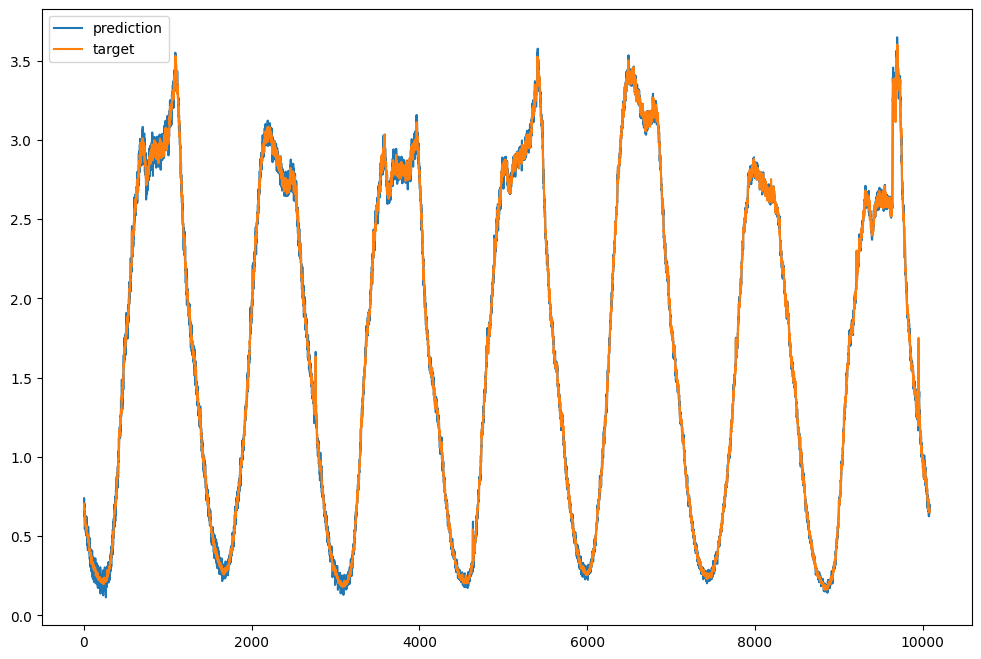

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.65109515, 0.74074382, 0.69683415, ..., 0.66745073, 0.70271134,
       0.66426557])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.704112],
       [0.689872],
       [0.666568],
       ...,
       [0.678984],
       [0.653888],
       [0.649888]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 2.7857674285769463 %
RMSE 0.03561955317854881
MAPE 2.7720317244529724 %


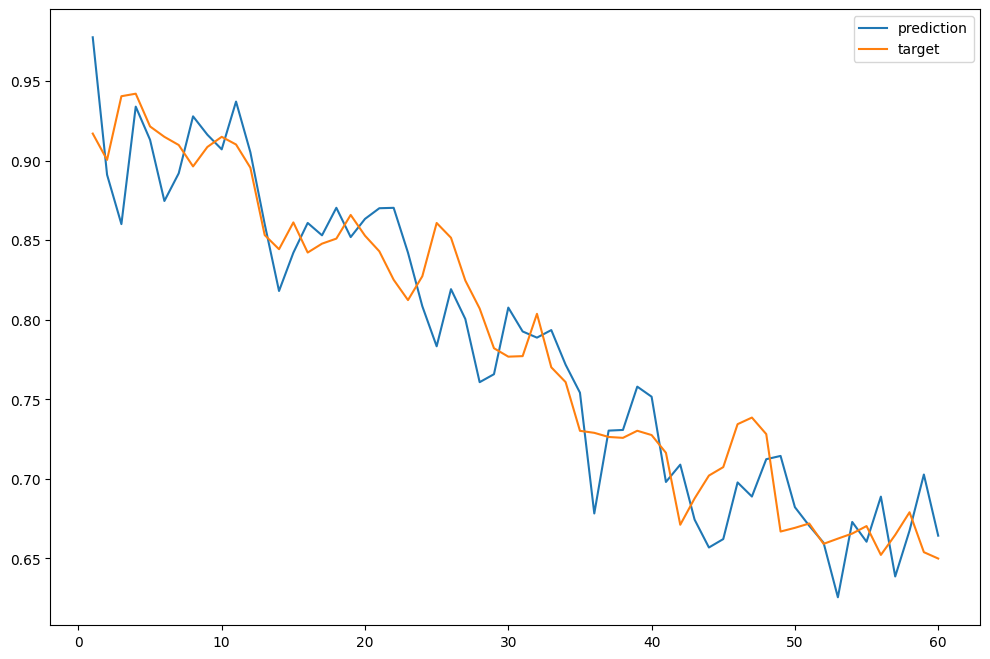

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.3022716409393719